## Imports, Reading In Data, and Cleaning

In [1]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
# Reading in data
df = pd.read_csv('Data/Airbnb_Open_Data.csv')
# examining shape and duplicates
print(f' Shape of DataFrame: {df.shape}\n Duplicated Rows: {df.duplicated().sum()}')
# previewing data
df.head()

/var/folders/pj/j8qg9t055bx9yt_m61ngrhyh0000gn/T/ipykernel_44531/3151957827.py:2: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Data/Airbnb_Open_Data.csv')


 Shape of DataFrame: (102599, 26)
 Duplicated Rows: 541


id                                              NAME      host id  \
0  1001254                Clean & quiet apt home by the park  80014485718   
1  1002102                             Skylit Midtown Castle  52335172823   
2  1002403               THE VILLAGE OF HARLEM....NEW YORK !  78829239556   
3  1002755                                               NaN  85098326012   
4  1003689  Entire Apt: Spacious Studio/Loft by central park  92037596077   

  host_identity_verified host name neighbourhood group neighbourhood  \
0            unconfirmed  Madaline            Brooklyn    Kensington   
1               verified     Jenna           Manhattan       Midtown   
2                    NaN     Elise           Manhattan        Harlem   
3            unconfirmed     Garry            Brooklyn  Clinton Hill   
4               verified    Lyndon           Manhattan   East Harlem   

        lat      long        country  ... service fee minimum nights  \
0  40.64749 -73.97237  United States  ...       $193            10.0   
1  40.75362 -73.98377  United States  ...        $28            30.0   
2  40.80902 -73.94190  United States  ...       $124             3.0   
3  40.68514 -73.95976  United States  ...        $74            30.0   
4  40.79851 -73.94399  United States  ...        $41            10.0   

  number of reviews last review  reviews per month review rate number  \
0               9.0  10/19/2021               0.21                4.0   
1              45.0   5/21/2022               0.38                4.0   
2               0.0         NaN                NaN                5.0   
3             270.0    7/5/2019               4.64                4.0   
4               9.0  11/19/2018               0.10                3.0   

  calculated host listings count  availability 365  \
0                            6.0             286.0   
1                            2.0             228.0   
2                            1.0             352.0   
3                            1.0             322.0   
4                            1.0             289.0   

                                         house_rules license  
0  Clean up and treat the home the way you'd like...     NaN  
1  Pet friendly but please confirm with me if the...     NaN  
2  I encourage you to use my kitchen, cooking and...     NaN  
3                                                NaN     NaN  
4  Please no smoking in the house, porch or on th...     NaN  

[5 rows x 26 columns]

In [3]:
# First dropping 541 duplicate rows
df.drop_duplicates(inplace=True)

# snakecasing all columns
df.columns = [col.replace(' ','_').lower() for col in df.columns]

### Viewing Data Types

In [4]:
df.dtypes
# host_identify_verified and instant_bookable can likely become a binary column
# noticing there are two neighborhood groups
# price and service fee should be a float

id                                  int64
name                               object
host_id                             int64
host_identity_verified             object
host_name                          object
neighbourhood_group                object
neighbourhood                      object
lat                               float64
long                              float64
country                            object
country_code                       object
instant_bookable                   object
cancellation_policy                object
room_type                          object
construction_year                 float64
price                              object
service_fee                        object
minimum_nights                    float64
number_of_reviews                 float64
last_review                        object
reviews_per_month                 float64
review_rate_number                float64
calculated_host_listings_count    float64
availability_365                  

### Adjusting Data Types:
- Host Identity verified will become binary 1 represents verification, all .28% of NaN values will default to unverified which seems reasonable given they are not confirmed to be verified.
- instant bookable will become binary as well, 1 represents instantly bookable, all non-instant bookable including null will default to not instantly bookable.
- Price and Service Fee become floats

In [5]:
# making dummy columns
df = pd.get_dummies(df,columns=(['host_identity_verified','instant_bookable']),drop_first=True)

# df.price contains floats and strings, will make it soley a str first
df.price = df.price.astype(str) 
# removing spaces, quotations, commas, and '$'
df.price = [each.replace(' ','').replace('"','').replace(',','').strip('$') for each in df.price]
# reverting back to float
df.price = df.price.astype(float)
# df.price contains floats and strings, will make it soley a str first

df.service_fee = df.service_fee.astype(str) 
# removing spaces, quotations, commas, and '$'
df.service_fee = [each.replace(' ','').replace('"','').replace(',','').strip('$') for each in df.service_fee]
# reverting back to float
df.service_fee = df.service_fee.astype(float)

### Renaming Columns

In [6]:
df.rename(columns={'neighbourhood_group':'borough', # appropriate name
                   'host_identity_verified_verified':'verified', # simplifying
                   'instant_bookable_True':'instant_bookable', # simplifying
                   'name':'description'},inplace=True) # more appropriate
df.borough.value_counts() # two mispelled boroughs to fix

Manhattan        43557
Brooklyn         41630
Queens           13197
Bronx             2694
Staten Island      949
brookln              1
manhatan             1
Name: borough, dtype: int64

In [7]:
df.borough.replace({"brookln": "Brooklyn", "manhatan": "Manhattan"},inplace=True)

### Viewing Null Values

In [8]:
df.isnull().sum()

id                                     0
description                          250
host_id                                0
host_name                            404
borough                               29
neighbourhood                         16
lat                                    8
long                                   8
country                              532
country_code                         131
cancellation_policy                   76
room_type                              0
construction_year                    214
price                                247
service_fee                          273
minimum_nights                       400
number_of_reviews                    183
last_review                        15832
reviews_per_month                  15818
review_rate_number                   319
calculated_host_listings_count       319
availability_365                     448
house_rules                        51842
license                           102056
verified        

### First I can drop certain columns
- After examining the read in error on column 25 'license', 99.9% of the column is null (102597 out of 102599 rows) so I will drop license.
- country and country_code are the same column and both depict that every listing is in the U.S. I will drop these columns because I know that every listing is in the U.S.
- last_review and reviews_per_month are redundant and contain many nulls, additionally number_of_reviews is a better indicator when viewing a listing.
- lastly house rules contain many nulls and will be dropped.
- calculated host listings count will be dropped due to error in data of host_id. The calculated host listing cannot be filled because there are no unique id's (explained in detail just below)

In [9]:
df.drop(columns=['license','country','country_code','last_review',
                 'reviews_per_month','house_rules','calculated_host_listings_count'],
        inplace=True)

## Handling Null Values

### I would like to  fill in null values based on the host_id, however the data is errored
- The data dictionary states the host_id is Airbnb's unique identifier for the host/user
- There should be unique host_id or id's to represent multiple listings by the same individual
- As we can see below, this is not the case, and to prove this, I have zipped latitude and longitude as one and returned a unique number much less than the entirety of the dataset
- I attempted to find the problem by investigating the host_id column.
    - Converting the column to a string and investigating if any spaces occurred before or after the numbers was proven to not be the case.
    - Investigating dtype of each value did not display what was wrong with the column either

In [10]:
print(f"The shape of the DataFrame: {df.shape}\
\nThe Unique amount of host_id's: {len(df.host_id.unique())}\
\nThe Unique amount of id's: {len(df.id.unique())}\
\nThe Unique latitude and longitude listings: {len((pd.Series(list(zip(df.lat,df.long))).unique()))}")

The shape of the DataFrame: (102058, 19)
The Unique amount of host_id's: 102057
The Unique amount of id's: 102058
The Unique latitude and longitude listings: 67163


**First I only keep data where I am comfortable droppping nulls from specific rows**
- I didn't find a reliable way to fill these specific null values

In [11]:
df.price.isnull().sum()

247

In [12]:
df = df.loc[(df.neighbourhood.notna()) # 16 Null rows, insignificant amount of null rows
            & (df.lat.notna()) # 8 Null rows, insignificant amount of null rows
            & (df.cancellation_policy.notna()) # 74 Null rows, no way to reliably fill cancellation_policy
            & (df.description.notna()) # 245 Null rows, no reliable way to fill listing description
            & (df.availability_365.notna()) # 448 Null rows, no reliable way to fill negative days
            & (df.price.notna())] # 247 Null rows; most sensitive row, avoiding data leakage and dropping nulls
df.shape

(101053, 19)

In [13]:
df.describe()
# negative min on availability 365
# minimum nights has min-max values which are egregious

id       host_id            lat           long  \
count  1.010530e+05  1.010530e+05  101053.000000  101053.000000   
mean   2.926105e+07  4.925547e+10      40.728089     -73.949657   
std    1.625612e+07  2.853817e+10       0.055883       0.049528   
min    1.001254e+06  1.236005e+08      40.499790     -74.249840   
25%    1.516286e+07  2.458402e+10      40.688700     -73.982580   
50%    2.933874e+07  4.912277e+10      40.722280     -73.954450   
75%    4.336164e+07  7.398489e+10      40.762790     -73.932350   
max    5.736742e+07  9.876313e+10      40.916970     -73.705220   

       construction_year          price    service_fee  minimum_nights  \
count      100874.000000  101053.000000  100814.000000   100682.000000   
mean         2012.486914     625.390904     125.057641        8.067738   
std             5.764113     331.654560      66.330028       28.354026   
min          2003.000000      50.000000      10.000000    -1223.000000   
25%          2007.000000     340.000000      68.000000        2.000000   
50%          2012.000000     625.000000     125.000000        3.000000   
75%          2017.000000     913.000000     183.000000        5.000000   
max          2022.000000    1200.000000     240.000000     5645.000000   

       number_of_reviews  review_rate_number  availability_365       verified  \
count      100925.000000       100755.000000     101053.000000  101053.000000   
mean           27.438662            3.277991        141.018842       0.498016   
std            49.338974            1.285113        135.411423       0.499999   
min             0.000000            1.000000        -10.000000       0.000000   
25%             1.000000            2.000000          3.000000       0.000000   
50%             7.000000            3.000000         96.000000       0.000000   
75%            30.000000            4.000000        268.000000       1.000000   
max          1024.000000            5.000000       3677.000000       1.000000   

       instant_bookable  
count     101053.000000  
mean           0.497719  
std            0.499997  
min            0.000000  
25%            0.000000  
50%            0.000000  
75%            1.000000  
max            1.000000

### Minimum Nights
"As such, any stay that extends for 28 days or longer is regarded as a long-term or monthly stay. Not all rental listings on Airbnb offer long-term stays since it’s the host’s job to decide on whether to make their properties available for such arrangements."
https://www.mashvisor.com/blog/airbnb-monthly-stays/

In [14]:
df.minimum_nights.describe()

count    100682.000000
mean          8.067738
std          28.354026
min       -1223.000000
25%           2.000000
50%           3.000000
75%           5.000000
max        5645.000000
Name: minimum_nights, dtype: float64

In [15]:
print(f"Shape of Dataframe by dropping column: {df.drop(columns='minimum_nights').shape}") # comparing shape

print(f"Shape of Dataframe with parameters met in accordance to airbnb rules: \
{df.loc[(df.minimum_nights >= 0) & (df.minimum_nights <=28)].shape}") # comparing shape

df.drop(columns='minimum_nights',inplace=True) # dropping column

Shape of Dataframe by dropping column: (101053, 18)
Shape of Dataframe with parameters met in accordance to airbnb rules: (87002, 19)


I will drop this column despite wanting to keep it for two reasons. 
- The data dictionary to this dataset has a column called "minimum_minimum_nights" which is defined as "the smallest minimum_night value from the calender (looking 365 nights in the future)." I believe there are many errors in minimum nights because data has merged or leaked in some way from minimum minimum nights
- I keep more data overall by dropping minimum nights

## Availability
- **The Data Dictionary defines availibility_365 as the following:** "*avaliability_x. The availability of the listing x days in the future as determined by the calendar. Note a listing may not be available because it has been booked by a guest or blocked by the host.*"
- This definition does not specifiy that the listing is limited to 365 days, however when viewing days further out than 426 days there is only one listing at 3670.0. I am going to assume this is a typo and fix this to 367.
- Additionally I am going to assume that any negative number is user error where a '-' was added and correct the entry to be positive.

In [16]:
df.availability_365.replace({3677.0:367},inplace=True) # correcting error
df.availability_365 = [num*-1 if num < 0 else num for num in df.availability_365] # correcting error

### To fill missing values, I will group-by latitude and longitude and use forward fill and backwards fill to fill missing values on columns that I find this method appropriate.

In [17]:
# associating host_id to host_name
df['host_name'] = df.groupby(['lat','long'])['host_name'].ffill().bfill()

# grouping lat and long to fill missing construction years for associated listing 
df['construction_year'] = df.groupby(['lat','long'])[['construction_year']].ffill().bfill()

## price
# df.price = df.groupby(['neighbourhood','host_id'])['price'].ffill().bfill()

# service fee
df.service_fee = df.groupby(['lat','long'])['service_fee'].ffill().bfill()

# number of reviews
df.number_of_reviews = df.groupby(['lat','long'])['number_of_reviews'].ffill().bfill()

# review rate
df.review_rate_number = df.groupby(['lat','long'])['review_rate_number'].ffill().bfill()

# availability
df.availability_365 = df.groupby(['lat','long'])['availability_365'].ffill().bfill()

In [18]:
df.describe()

id       host_id            lat           long  \
count  1.010530e+05  1.010530e+05  101053.000000  101053.000000   
mean   2.926105e+07  4.925547e+10      40.728089     -73.949657   
std    1.625612e+07  2.853817e+10       0.055883       0.049528   
min    1.001254e+06  1.236005e+08      40.499790     -74.249840   
25%    1.516286e+07  2.458402e+10      40.688700     -73.982580   
50%    2.933874e+07  4.912277e+10      40.722280     -73.954450   
75%    4.336164e+07  7.398489e+10      40.762790     -73.932350   
max    5.736742e+07  9.876313e+10      40.916970     -73.705220   

       construction_year          price    service_fee  number_of_reviews  \
count      101053.000000  101053.000000  101053.000000      101053.000000   
mean         2012.490109     625.390904     125.050736          27.440066   
std             5.764582     331.654560      66.333791          49.364420   
min          2003.000000      50.000000      10.000000           0.000000   
25%          2008.000000     340.000000      68.000000           1.000000   
50%          2012.000000     625.000000     125.000000           7.000000   
75%          2017.000000     913.000000     183.000000          30.000000   
max          2022.000000    1200.000000     240.000000        1024.000000   

       review_rate_number  availability_365       verified  instant_bookable  
count       101053.000000     101053.000000  101053.000000     101053.000000  
mean             3.276667        141.032062       0.498016          0.497719  
std              1.285121        134.907604       0.499999          0.499997  
min              1.000000          0.000000       0.000000          0.000000  
25%              2.000000          4.000000       0.000000          0.000000  
50%              3.000000         96.000000       0.000000          0.000000  
75%              4.000000        268.000000       1.000000          1.000000  
max              5.000000        426.000000       1.000000          1.000000

### Filling Missing Boroughs

In [19]:
def column_summary(column): # quick function to help me visualize issues with any column
    null = column.isnull().sum()
    rows = df.shape[0]
    null_percent = str((null/rows)*100)[:4]
    print(f"There are {null} Null rows out of {rows} rows, {null_percent}% of the column is null")
    print(f"Value Counts: \n{column.value_counts()}")

In [20]:
column_summary(df.borough)

There are 14 Null rows out of 101053 rows, 0.01% of the column is null
Value Counts: 
Manhattan        43156
Brooklyn         41212
Queens           13066
Bronx             2662
Staten Island      943
Name: borough, dtype: int64


In [21]:
df[df.borough.isnull()][['neighbourhood']].neighbourhood.unique()

array(['Clinton Hill', 'East Harlem', 'Bushwick', 'Williamsburg',
       'Harlem', 'Queens Village', 'Bedford-Stuyvesant', 'East Village',
       'Upper West Side'], dtype=object)

**Can simply create a dictionary to fill in the missing boroughs based on associated neighbourhood**

In [22]:
b_dict = { # Manhattan
          'Washington Heights':'Manhattan','East Village':'Manhattan',
          'Upper East Side':'Manhattan','Chelsea':'Manhattan',
          'East Harlem':'Manhattan','Harlem':'Manhattan',
          'Chinatown':'Manhattan','Upper West Side':'Manhattan',
           # Brooklyn
          'Clinton Hill':'Brooklyn','Williamsburg':'Brooklyn',
          'Bushwick':'Brooklyn','Prospect Heights':'Brooklyn','Bedford-Stuyvesant':'Brooklyn',
           # Queens
          'Woodside':'Queens','Queens Village':'Queens',
           # Bronx
          'Eastchester':'Bronx'
         }

df.borough = df.borough.fillna(df.neighbourhood.map(b_dict)) # filling borough with dictionary

column_summary(df.borough)

There are 0 Null rows out of 101053 rows, 0.0% of the column is null
Value Counts: 
Manhattan        43163
Brooklyn         41218
Queens           13067
Bronx             2662
Staten Island      943
Name: borough, dtype: int64


### Checking cases where the borough is in the neighbourhood name
- The value counts for if the string contains a borough should be an unique instane where the name of the neighborhood contains the borough intently. 
- The sum of value_counts should equal the sum of unique instances

#### Brooklyn

In [23]:
df[df['neighbourhood'].str.contains("Brooklyn", na=False)].neighbourhood.value_counts()

Brooklyn Heights     299
Downtown Brooklyn    174
Name: neighbourhood, dtype: int64

In [24]:
df.neighbourhood.str.contains('Brooklyn').value_counts() # 308 + 175 = 483

False    100580
True        473
Name: neighbourhood, dtype: int64

#### Bronx

In [25]:
df[df['neighbourhood'].str.contains("Bronx", na=False)].neighbourhood.value_counts()

Bronxdale    44
Name: neighbourhood, dtype: int64

In [26]:
df.neighbourhood.str.contains('Bronx').value_counts()

False    101009
True         44
Name: neighbourhood, dtype: int64

#### Queens

In [27]:
df[df['neighbourhood'].str.contains("Queens", na=False)].neighbourhood.value_counts()

Queens Village    145
Name: neighbourhood, dtype: int64

In [28]:
df.neighbourhood.str.contains('Queens').value_counts()

False    100908
True        145
Name: neighbourhood, dtype: int64

#### Manhattan and Staten Island

In [29]:
df[df['neighbourhood'].str.contains("Manhattan", na=False)].neighbourhood.value_counts()

Manhattan Beach    22
Name: neighbourhood, dtype: int64

In [30]:
df.neighbourhood.str.contains('Manhattan').value_counts()

False    101031
True         22
Name: neighbourhood, dtype: int64

In [31]:
df[df['neighbourhood'].str.contains("Bay Terrace", na=False)].neighbourhood.value_counts()

Bay Terrace                   8
Bay Terrace, Staten Island    4
Name: neighbourhood, dtype: int64

In [32]:
df[df['neighbourhood'].str.contains("Chelsea", na=False)].neighbourhood.value_counts()

Chelsea                   2245
Chelsea, Staten Island       1
Name: neighbourhood, dtype: int64

In [33]:
df[df['neighbourhood'].str.contains("Staten Island", na=False)].neighbourhood.value_counts()

Bay Terrace, Staten Island    4
Chelsea, Staten Island        1
Name: neighbourhood, dtype: int64

In [34]:
# for consistency I am keeping the associated borough next to repeating neighbourhood names
df.neighbourhood.replace({"Chelsea": "Chelsea, Manhattan", 
                          "Bay Terrace": "Bay Terrace, Queens"},inplace=True)

In [35]:
# lastly I will drop host_id and keep id to avoid redundency, 
# both are separate unique numbers for each listing 
df.drop(columns='host_id',inplace=True)

In [36]:
df.shape

(101053, 17)

In [37]:
df.isnull().sum()

id                     0
description            0
host_name              0
borough                0
neighbourhood          0
lat                    0
long                   0
cancellation_policy    0
room_type              0
construction_year      0
price                  0
service_fee            0
number_of_reviews      0
review_rate_number     0
availability_365       0
verified               0
instant_bookable       0
dtype: int64

In [38]:
df.describe()

id            lat           long  construction_year  \
count  1.010530e+05  101053.000000  101053.000000      101053.000000   
mean   2.926105e+07      40.728089     -73.949657        2012.490109   
std    1.625612e+07       0.055883       0.049528           5.764582   
min    1.001254e+06      40.499790     -74.249840        2003.000000   
25%    1.516286e+07      40.688700     -73.982580        2008.000000   
50%    2.933874e+07      40.722280     -73.954450        2012.000000   
75%    4.336164e+07      40.762790     -73.932350        2017.000000   
max    5.736742e+07      40.916970     -73.705220        2022.000000   

               price    service_fee  number_of_reviews  review_rate_number  \
count  101053.000000  101053.000000      101053.000000       101053.000000   
mean      625.390904     125.050736          27.440066            3.276667   
std       331.654560      66.333791          49.364420            1.285121   
min        50.000000      10.000000           0.000000            1.000000   
25%       340.000000      68.000000           1.000000            2.000000   
50%       625.000000     125.000000           7.000000            3.000000   
75%       913.000000     183.000000          30.000000            4.000000   
max      1200.000000     240.000000        1024.000000            5.000000   

       availability_365       verified  instant_bookable  
count     101053.000000  101053.000000     101053.000000  
mean         141.032062       0.498016          0.497719  
std          134.907604       0.499999          0.499997  
min            0.000000       0.000000          0.000000  
25%            4.000000       0.000000          0.000000  
50%           96.000000       0.000000          0.000000  
75%          268.000000       1.000000          1.000000  
max          426.000000       1.000000          1.000000

In [39]:
df.to_csv('Data/cleaned_airbnb.csv',index=False)

## EDA

In [40]:
df = pd.read_csv('Data/cleaned_airbnb.csv')

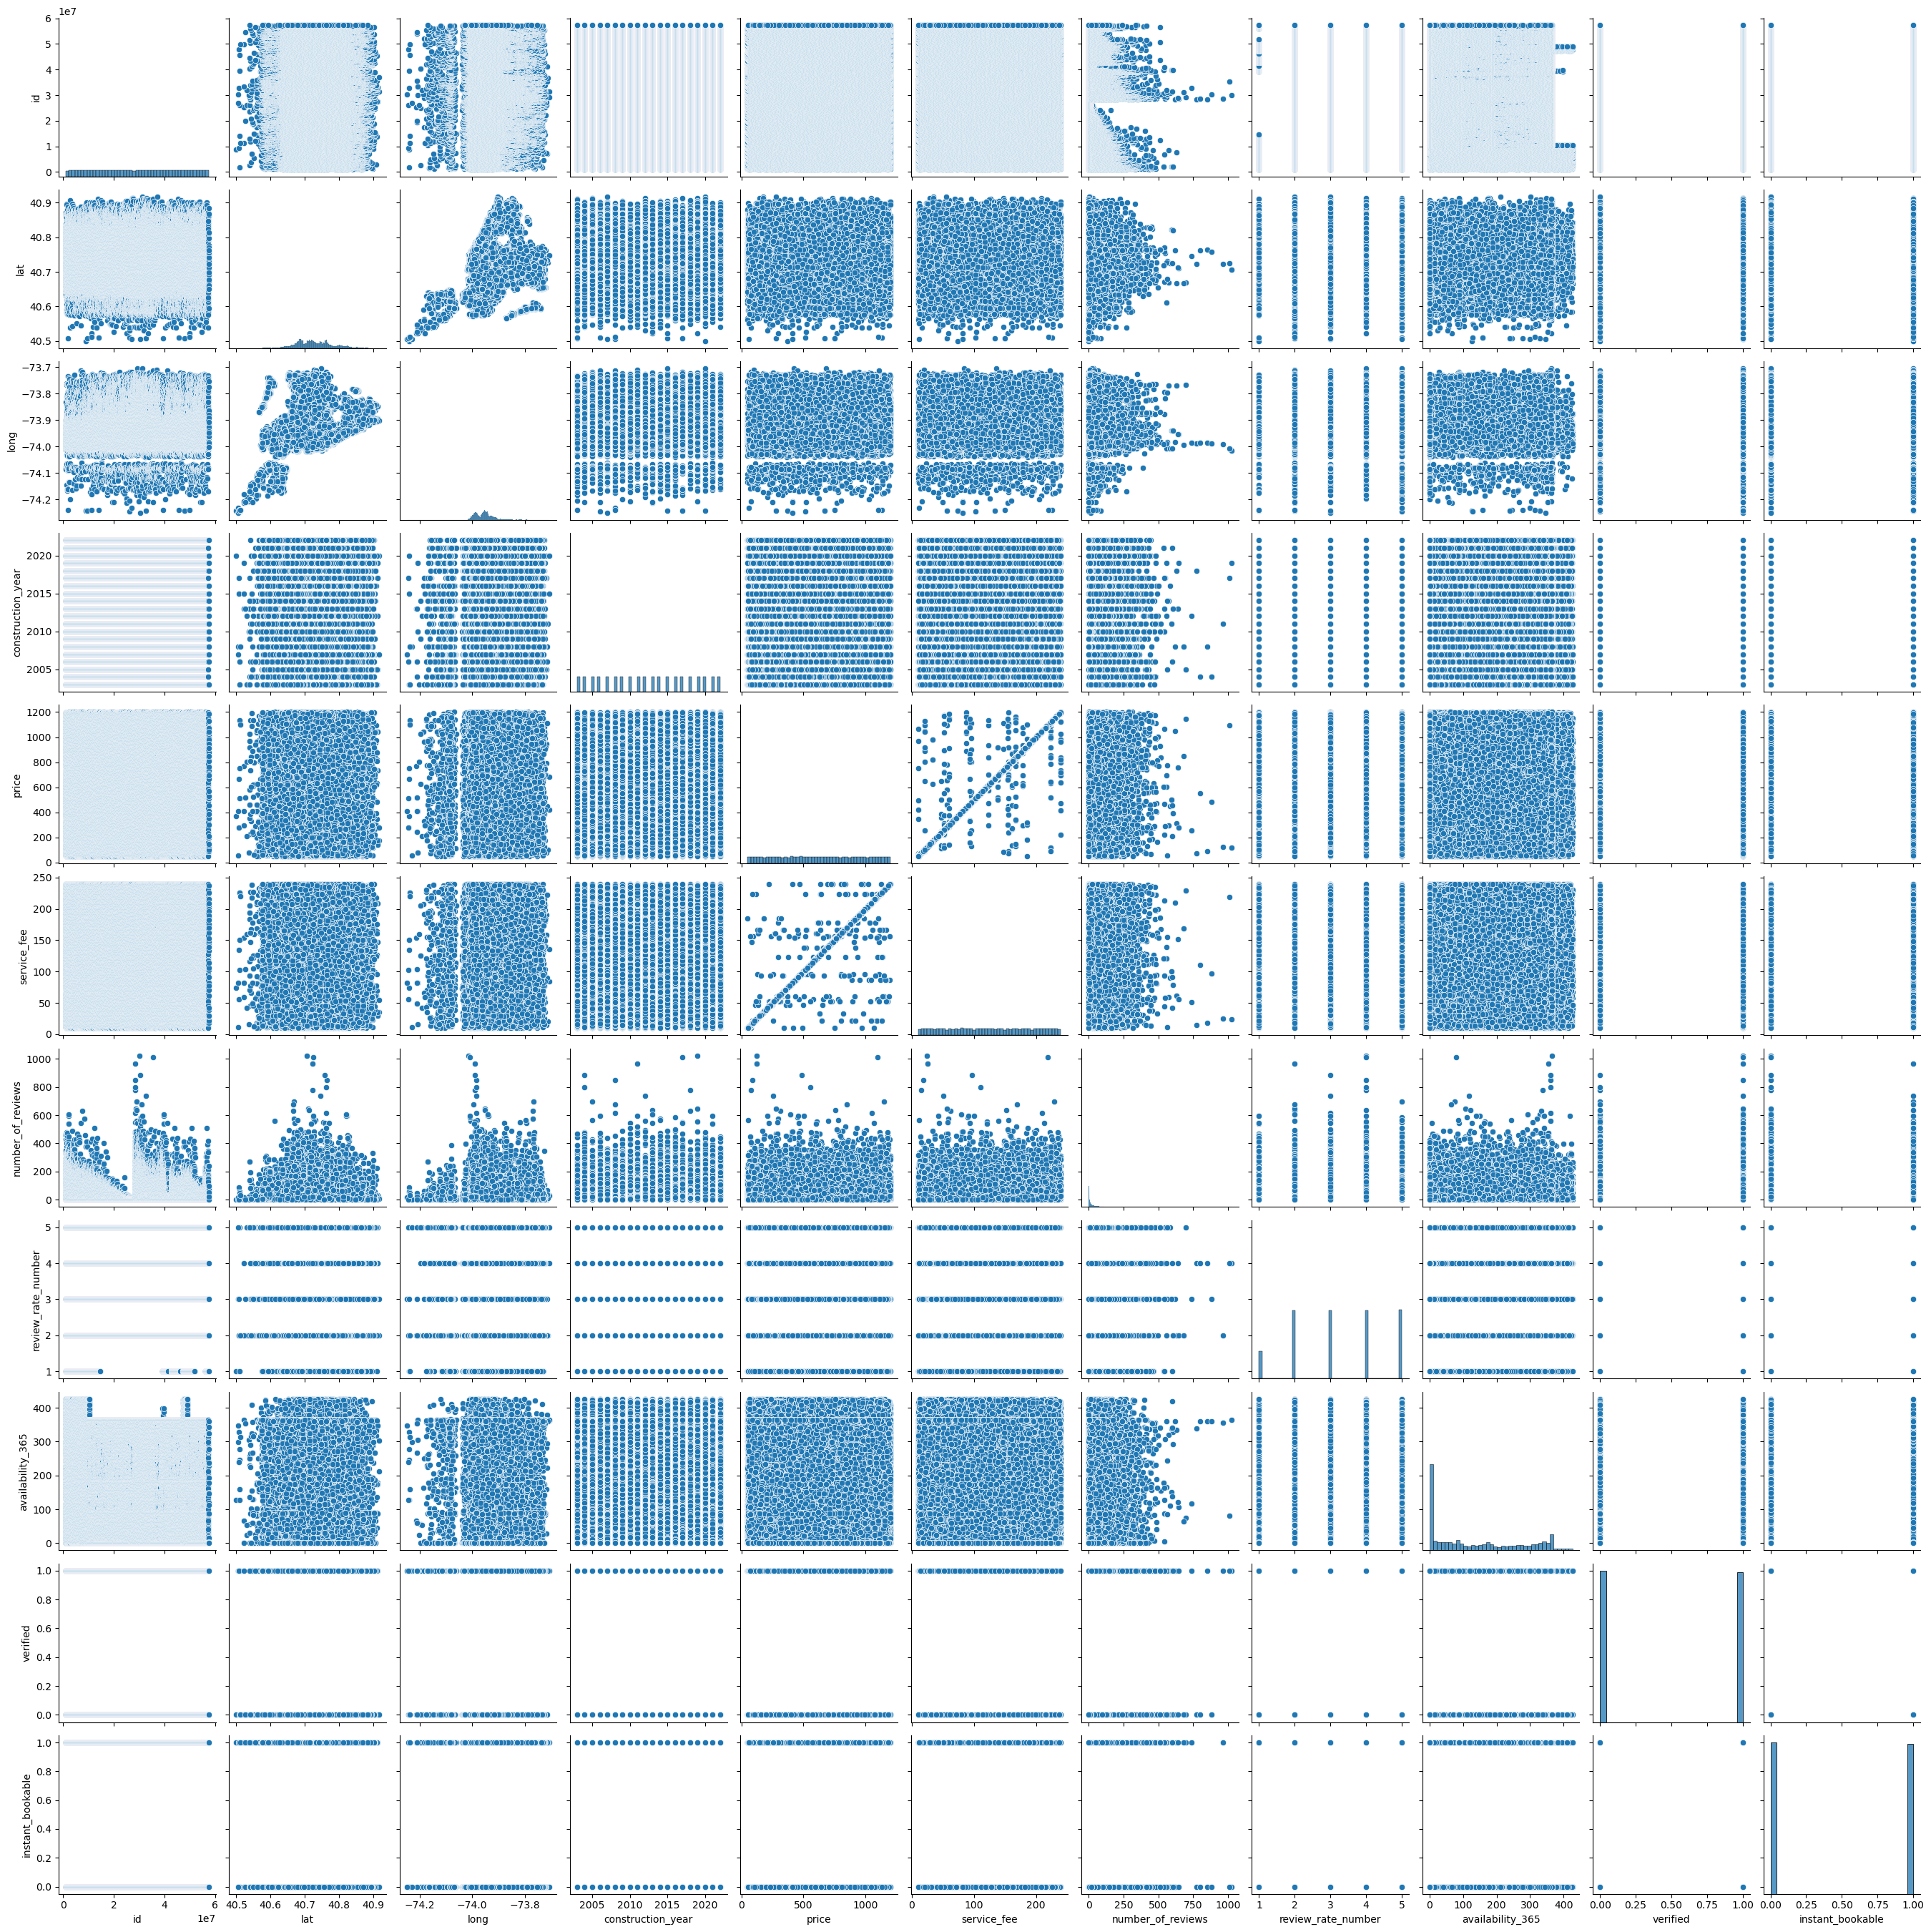

In [41]:
# overview of any correlated features
sns.pairplot(df);

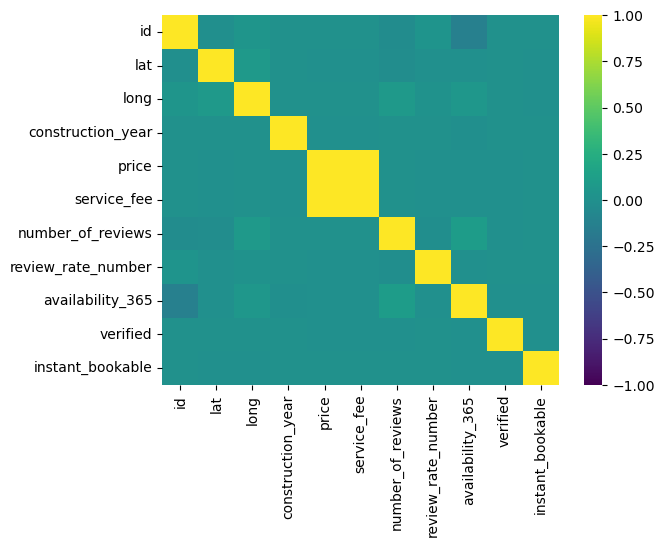

In [43]:
sns.heatmap(df.corr(),cmap='viridis',vmin=-1);

Overall, due to the high number of categorical features, there are few correlations to be made aside from service fee and price, I will examine several categorical features and potential relationships.

## Breakdown by Borough and Neighbourhood

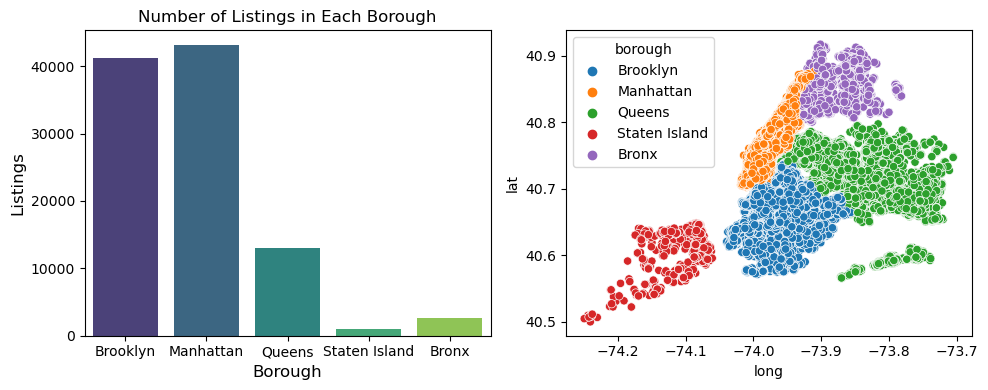

In [44]:
fig, ax =plt.subplots(1,2,figsize=(10,4),tight_layout=True)

sns.countplot(x=df.borough, palette='viridis',ax=ax[0]) # listings by borough
fig = plt.gcf()
ax[0].set_title('Number of Listings in Each Borough')
ax[0].set_xlabel('Borough',fontsize=12)
ax[0].set_ylabel('Listings',fontsize=12);

sns.scatterplot(x=df.long,y=df.lat,hue=df.borough,ax=ax[1]); # geographical visual

Worth noting the imbalanced nature of the data. Brookyln and Manhattan make up the bulk of Airbnb listings.

In [45]:
# grouping avaerage cost of AirBnb by neighbourhood
neighbourhood_prices = df.groupby(['borough','neighbourhood'])[['price']].mean().sort_values(
    ['borough','price'],ascending=True)

In [46]:
# function to graph cheapest and most expensive neighbourhoods to stay by borough
def plot_neighbourhood_prices(borough): 
    
    target = neighbourhood_prices.copy() # target is simply a copy of neighbourhood_prices
    target['neighbourhood'] = [each[1] for each in target.index] # using only neighbourhood from Multi-Index
    target.set_index('neighbourhood',inplace=True) # setting neighbourhood as the index
    
    # 5 conditions for the 5 boroughs
    if borough.lower() == 'bronx':
        target = target[0:48]
    elif borough.lower() == 'brooklyn':
        target = target[48:96]
    elif borough.lower() == 'manhattan':
        target = target[96:128]
    elif borough.lower() == 'queens':
        target = target[128:180]
    elif borough.lower() == 'staten island':
        target = target[180:]
           
    fig, ax = plt.subplots(1,2,figsize=(16,5),tight_layout=True) # defining plot
        
    ax[0].barh(target.index[-5:],target.price[-5:]) # most expensive
    ax[0].set_title(f"{str(borough).capitalize()}'s 5 most expensive neighbourhoods to stay",
                    fontsize=16)
    ax[0].set_xlabel('Cost of AirBnb on Average',fontsize=15)
    ax[0].tick_params(axis='both', which='major', labelsize=14)
    
    ax[1].barh(target.index[:5],target.price[:5]) # least expensive
    ax[1].set_title(f"{str(borough).capitalize()}'s 5 least expensive neighbourhoods to stay",
                    fontsize=16)
    ax[1].set_xlabel('Cost of AirBnb on Average',fontsize=15)
    ax[1].tick_params(axis='both', which='major', labelsize=14)
    
    # average price of respective borough to display above graphs
    if borough.lower() == 'staten island':
        avg_price = df[df.borough == 'Staten Island'].price.mean()
    else:
        avg_price = df[df.borough == str(borough).capitalize()].price.mean()  
    print(f"{str(borough.capitalize())}'s average price of an AirBnb: ${round(avg_price)}")

Bronx's average price of an AirBnb: $628


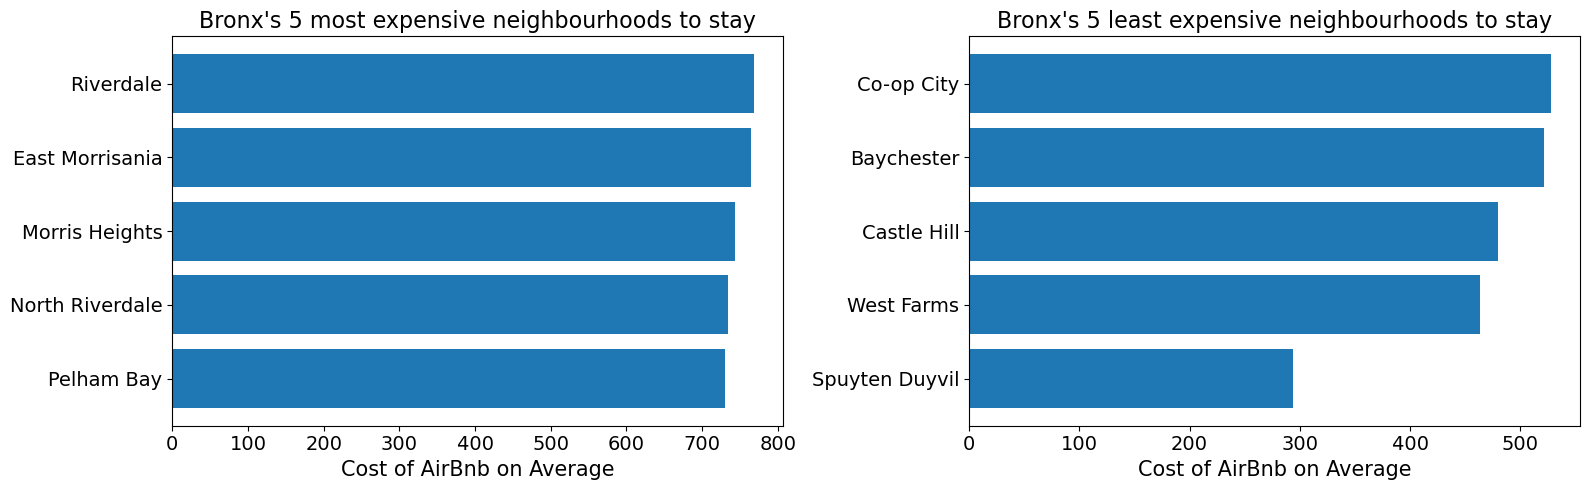

In [47]:
plot_neighbourhood_prices('bronx')

Brooklyn's average price of an AirBnb: $626


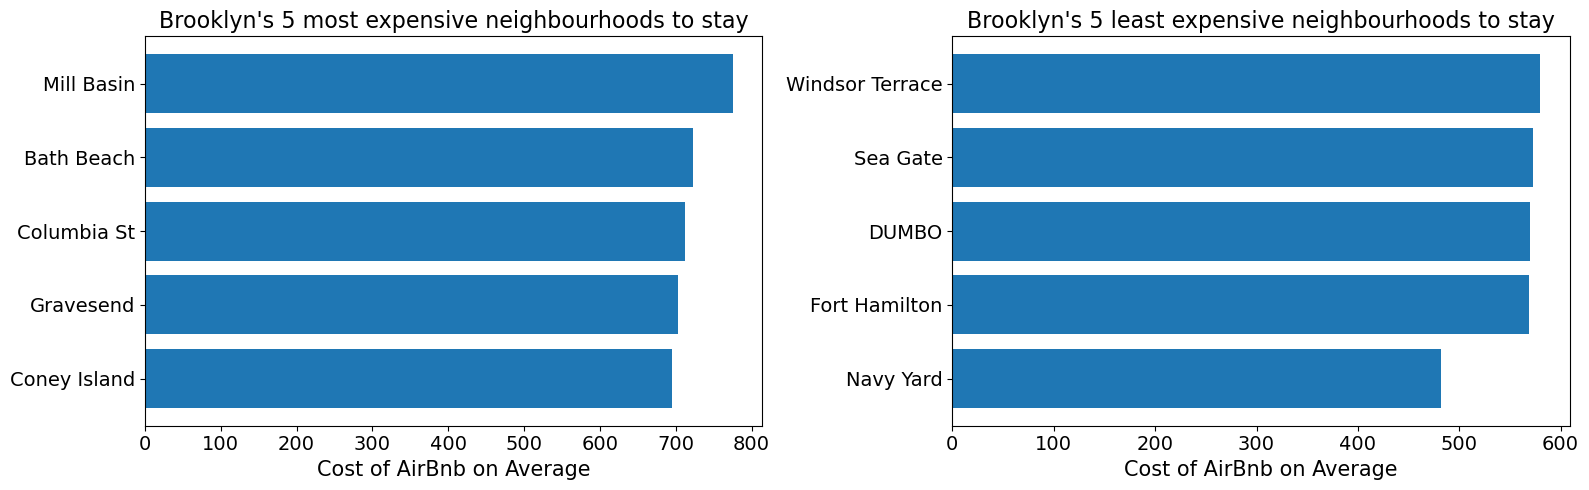

In [48]:
plot_neighbourhood_prices('brooklyn')

Manhattan's average price of an AirBnb: $623


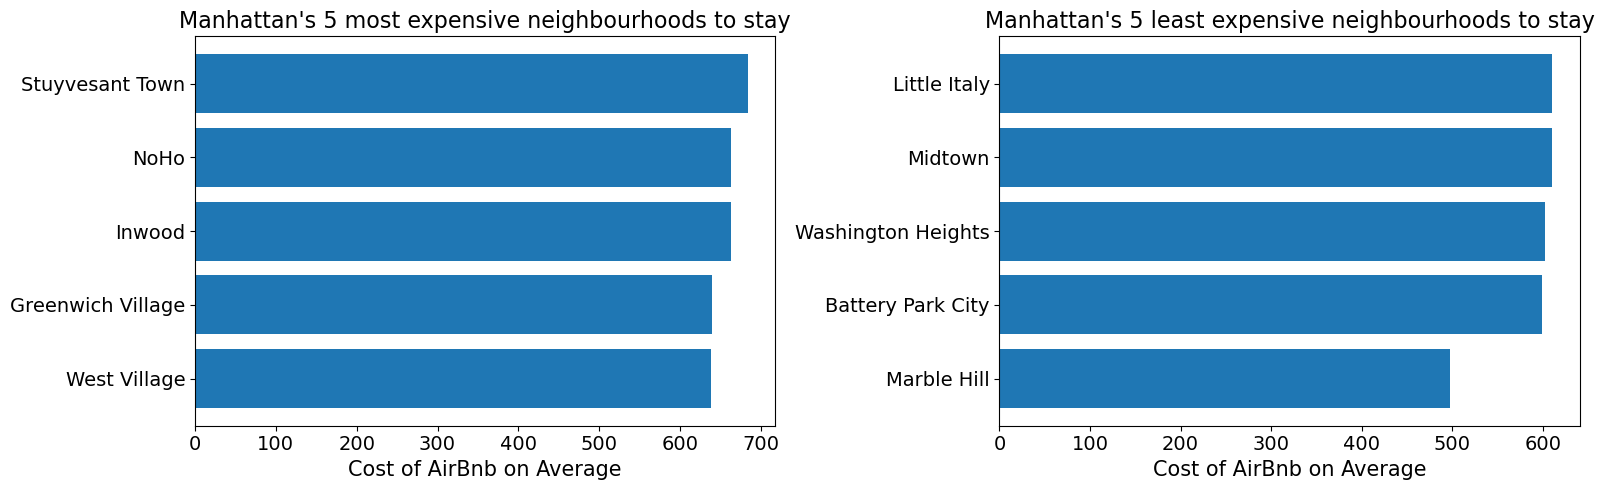

In [49]:
plot_neighbourhood_prices('manhattan')

Queens's average price of an AirBnb: $630


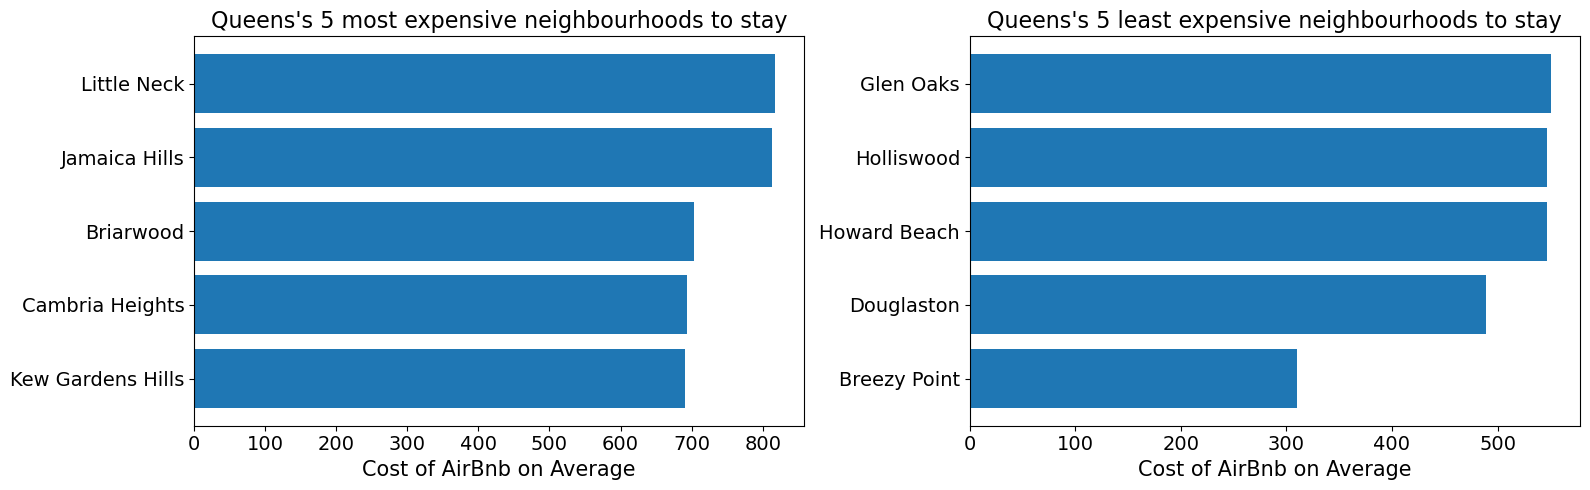

In [50]:
plot_neighbourhood_prices('queens')

Staten island's average price of an AirBnb: $624


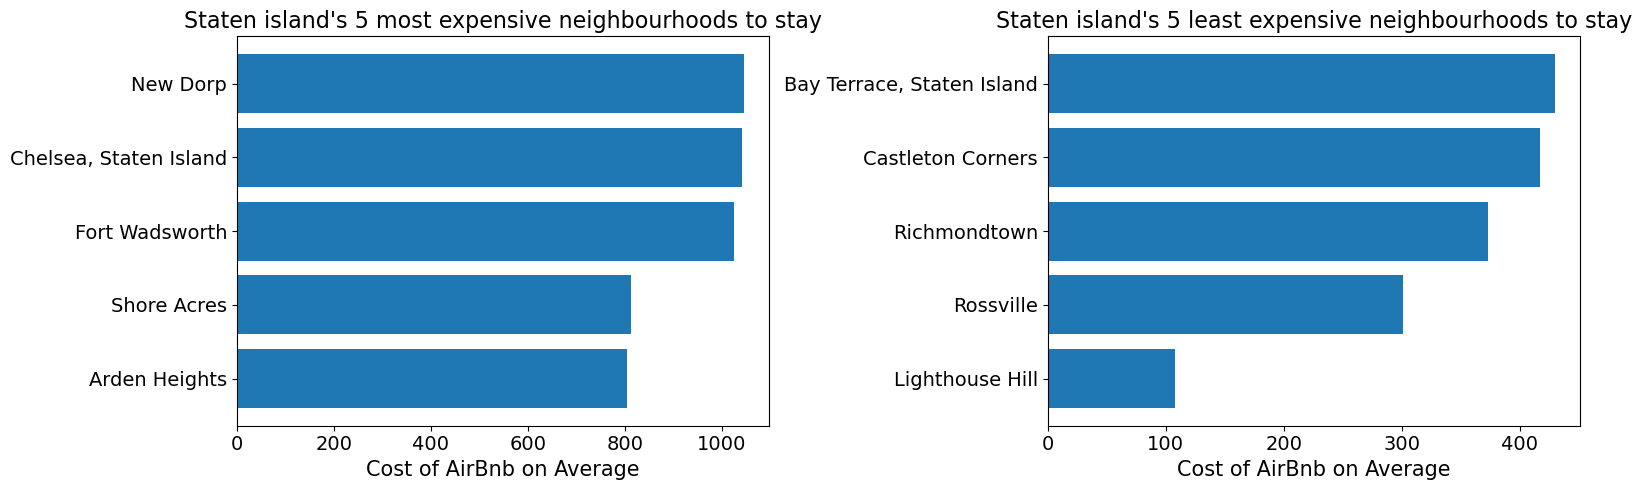

In [51]:
plot_neighbourhood_prices('staten island')

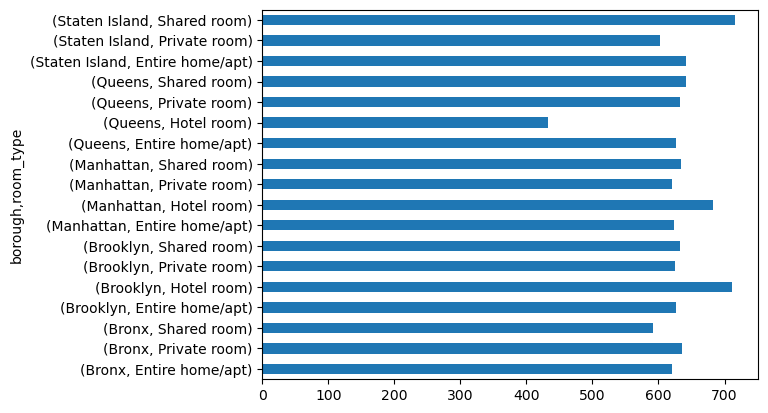

In [52]:
# average price by room type
df.groupby(['borough','room_type'])['price'].mean().round(2).plot(kind='barh');

### Tableau Dashboard

In [53]:
%%html
<div class='tableauPlaceholder' id='viz1668632832474' style='position: relative'><noscript><a href='#'><img alt='Dashboard 1 ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;NY&#47;NYCAirBnb_16685372801110&#47;Dashboard1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='NYCAirBnb_16685372801110&#47;Dashboard1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;NY&#47;NYCAirBnb_16685372801110&#47;Dashboard1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-US' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1668632832474');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.minWidth='420px';vizElement.style.maxWidth='650px';vizElement.style.width='100%';vizElement.style.minHeight='587px';vizElement.style.maxHeight='887px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.minWidth='420px';vizElement.style.maxWidth='650px';vizElement.style.width='100%';vizElement.style.minHeight='587px';vizElement.style.maxHeight='887px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else { vizElement.style.width='100%';vizElement.style.height='1227px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

Brooklyn and Manhattan make up the bulk of listings in this dataset while Staten Island has both the most expensive and cheapest listings. There aren't many demographics to investigate, so detailed reasoning based on this dataset is inconclusive. The average price of an AirBnb for the entirety of the dataset is 625 and each borough has an average listing at or near 625. Additionally a hotel room in Queens is significantly cheaper than any other option listed.

However when examining the cost of hotel rooms compared to AirBnb's further, while hotel rooms appear to be more expensive, there are far fewer hotel rooms (and shared rooms) listed in the dataset. Additionally, hotel rooms in both Manhattan and Brooklyn are more expensive compared to Airbnb listings (Manhattan and Brooklyn make up the bulk of the data)

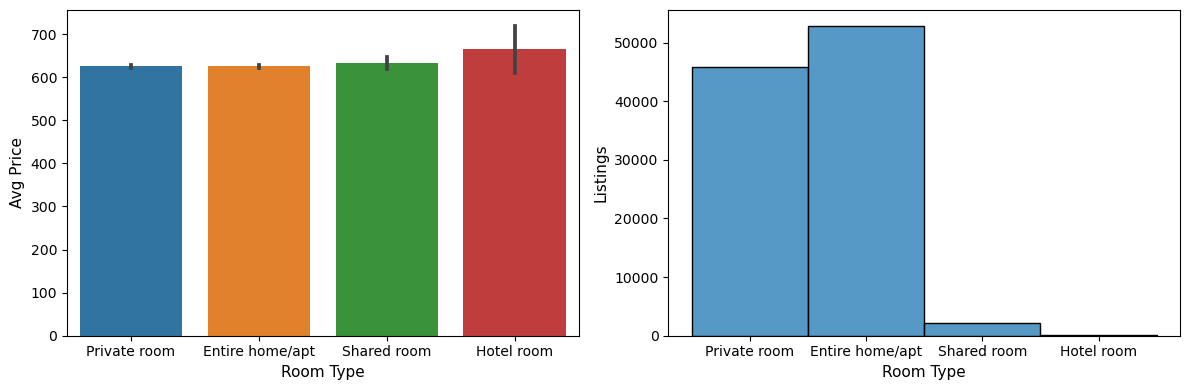

In [54]:
fig, ax =plt.subplots(1,2,figsize=(12,4),tight_layout=True)

sns.barplot(x=df.room_type,y=df.price, ax=ax[0]) # room type Avg price
ax[0].set_xlabel('Room Type',fontsize=11)
ax[0].set_ylabel('Avg Price',fontsize=11)

sns.histplot(df.room_type, ax=ax[1]); # distribution
ax[1].set_xlabel('Room Type',fontsize=11)
ax[1].set_ylabel('Listings',fontsize=11);

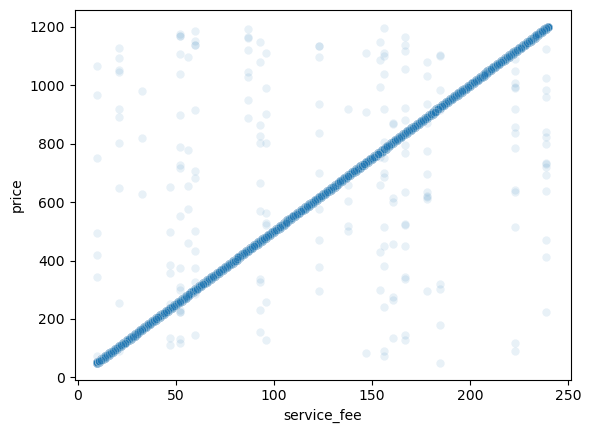

In [55]:
sns.scatterplot(x=df.service_fee,y=df.price,
                alpha=.1); # alpha of .1 to reduce noise of outliers

As the service fee increases, price is expected to increase, all else holding constant.

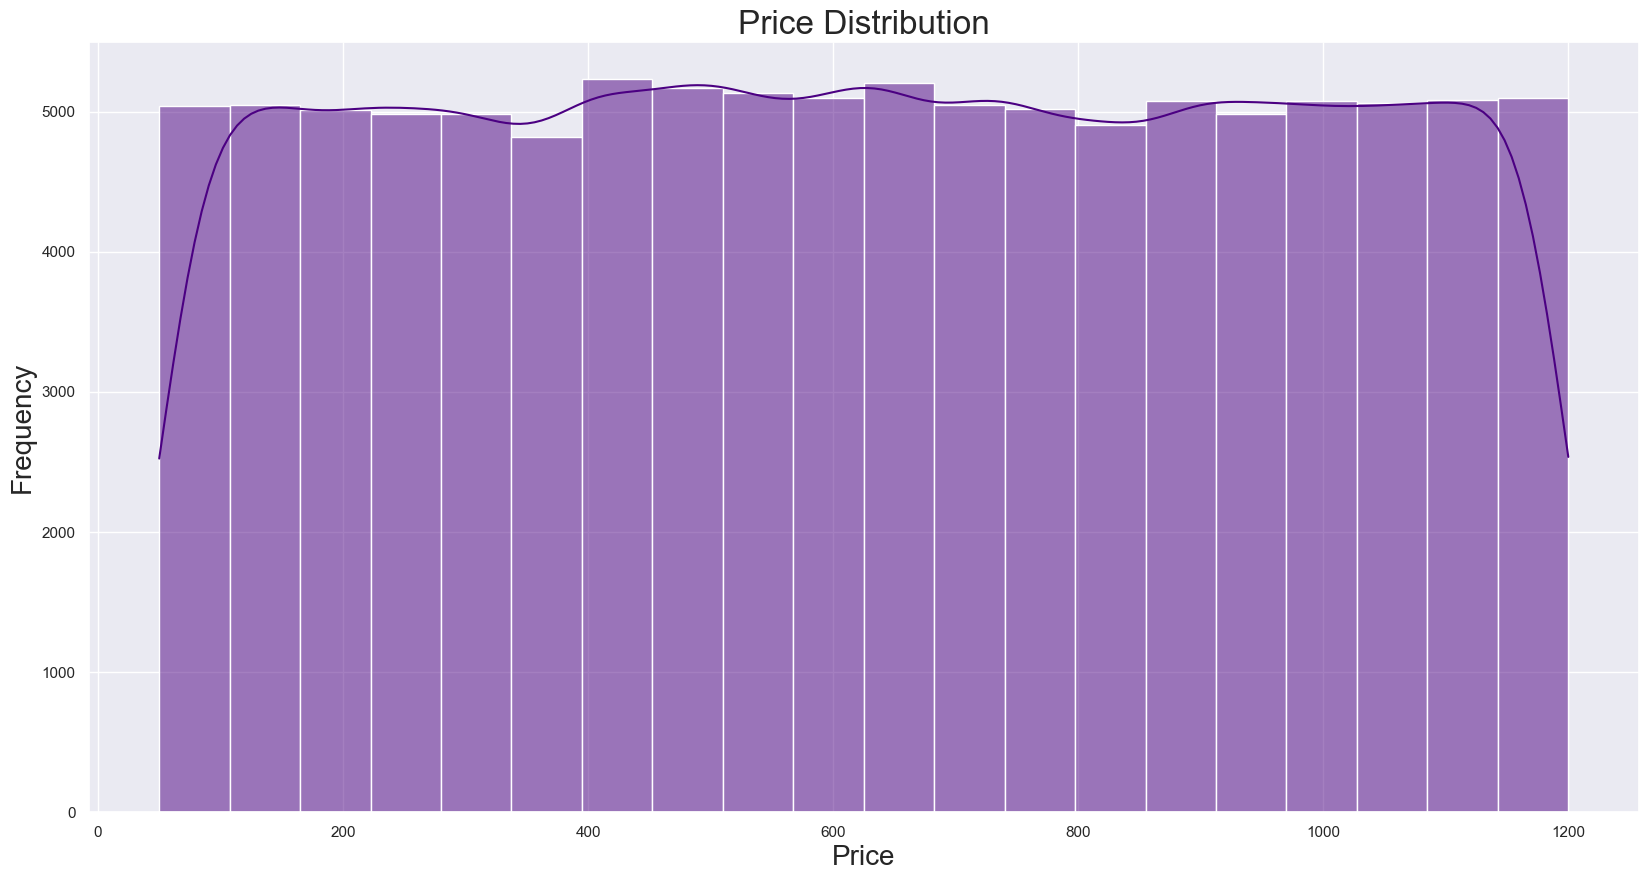

In [59]:
# Examining Price Distribution
ax = sns.histplot(df.price,log_scale=False,
             kde=True,color='indigo',bins=20)

sns.set(rc = {'figure.figsize':(20,10)});

ax.set_title('Price Distribution',fontsize=24)
ax.set_xlabel('Price', fontsize=20);
ax.set_ylabel('Frequency', fontsize=20);

In [57]:
# Examining the amount of constructions each year
constructions_per_year = df.groupby('construction_year')['construction_year'].count()

fig = px.bar(constructions_per_year, 
            x=constructions_per_year.index, 
            y=constructions_per_year.values, 
            labels={'x': 'Year', 'y': 'Total Constructions'},
            text=[str(i) for i in constructions_per_year.values],
            title='Number of constructions per year',
            template='plotly_dark'
)

fig.update_layout(font=dict(size=20, color='white', family='Avenir'))

fig.show()

In [58]:
# Checking if construction affects price
price_per_year = df.groupby('construction_year')['price'].median()

# Let's plot them using plotly's barplot with value counts
fig = px.bar(price_per_year,
            x=price_per_year.index,
            y=price_per_year.values,
            labels={'x': 'Construction year', 'y': 'Average price'},
            text=['$' + str(int(i)) for i in price_per_year.values],
            title='Average price per construction year',
            color_discrete_sequence=px.colors.sequential.RdBu,
            template='plotly_dark'
)

fig.update_layout(font=dict(size=16, color='white', family='Avenir'))

fig.show()

As with the rest of the data, there are no major correlations to price changes aside from service fee. I'd have thought that constructions may have impacted the price but it does not as the price continues to hover around the overall mean.

## Conclusions and Recommendations:

There are fewer correlations to the cost of an Airbnb in NYC than I had anticipated, however I find that the data is lacking. I believe there are key demographics missing that could be analyzed further as to why specific neighbourhoods are more expensive than others. Such as events, where I anticipate Manhattan may have more expensive options given they host a variety of venues such as Broadway and Madison Square Garden.

Additionally, according to https://criminaljustice.cityofnewyork.us/individual_charts/violent-crime-rate-by-borough/ the Bronx has the highest crime rate out of any borough. Despite this, the Bronx is the second most expensive borough to stay in according to this data. Again it is worth mentioning the data is not balanced and Brooklyn/Manhattan make up the bulk of listings in this data.